In [1]:
%%javascript
$(document).ready(() => {
    // Удаление данного блока кода с конечного результата.
    $('div.code_cell').first().css('display', 'none');

    // Включение автоматического переноса слов в параграфе.
    $('div.text_cell p').css('hyphens', 'auto');

    // Включение растягивания текста на всю доступную длину.
    $('div.text_cell p').css('text-align', 'justify');
});

<IPython.core.display.Javascript object>

<h3><b>Лабораторная работа №9: Рекомендательные системы</b></h3>

<p lang="ru">Рекомендательные системы — программы, которые пытаются предсказать, какие объекты будут интересны пользователю, имея определенную информацию о его профиле. Две основные стратегии создания рекомендательных систем — фильтрация на основе содержания и коллаборативная фильтрация. При фильтрации на основе содержания создаются профили пользователей и объектов, профили пользователей могут включать демографическую информацию или ответы на определённый набор вопросов, профили объектов могут включать названия жанров, имена актёров, имена исполнителей и другую атрибутивную информацию в зависимости от типа объекта. При коллаборативной фильтрации используется информация о поведении пользователей в прошлом — например, информация о покупках или оценках. В этом случае не имеет значения, с какими типами объектов ведётся работа, но при этом могут учитываться неявные характеристики, которые сложно было бы учесть при создании профиля.</p>

In [2]:
%autosave 300

Autosaving every 300 seconds


In [3]:
import warnings

# Игнорирование некоторых оповещающих сообщений библиотек.
warnings.filterwarnings('ignore', category=FutureWarning)

In [4]:
import numpy as np
import pandas as pd

In [5]:
# Импортирование функции для чтения MATLAB файлов.
from scipy.io import loadmat

In [6]:
# Импортирование функции индикатора выполнения.
from tqdm import tqdm_notebook

In [7]:
# Импортирование библиотеки для работы с графиками.
from matplotlib import pyplot
%matplotlib inline

In [8]:
# Установка начального значения для генератора случайных чисел.
# Данное действие требуется для воспроизведения результатов опыта.
np.random.seed(0)

<p lang="ru"><b>Пункт №1:&nbsp;</b>Загрузка первого предоставленного набора данных <tt>ex9movies.mat</tt> при помощи внешней библиотеки scipy. Текущий набор данных содержит информацию о пользователях и рейтингах к определенным фильмам.</p>

In [9]:
data_x = loadmat('./datasets/ex9movies.mat')['Y']

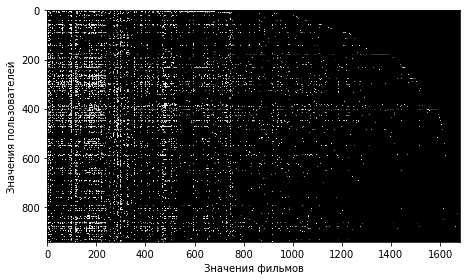

In [10]:
# Создание совместного полотна для графиков.
pyplot.figure(figsize=(14, 4))

# Построение изображения матрицы рейтингов.
pyplot.imshow(data_x.T, cmap='gray')

# Настройка координатных осей графика.
pyplot.xlabel('Значения фильмов')
pyplot.ylabel('Значения пользователей')

# Настройка отображения.
pyplot.tight_layout()

# Отображение графика.
pyplot.show()

In [11]:
# Вычисление количества пользователей и фильмов.
n_items = data_x.shape[0]
n_users = data_x.shape[1]

<p lang="ru"><b>Пункт №2:&nbsp;</b>Загрузка второго предоставленного набора данных <tt>movie_ids.csv</tt> при помощи внешней библиотеки pandas. Текущий набор данных содержит информацию о нескольких тысячах фильмах, снятых за определенный промежуток времени.</p>

In [12]:
movie_data = pd.read_csv('./datasets/movie_ids.csv', sep=';')

<p lang="ru"><b>Пункт №3:&nbsp;</b>Реализация функции вычисления косинусного сходства между несколькими векторами. Косинусное сходство — это мера сходства между двумя векторами предгильбертового пространства, которая используется для измерения косинуса угла между ними. Одна из причин популярности косинуснуго сходства состоит в том, что оно эффективно в качестве оценочной меры, особенно для разреженных векторов, так как необходимо учитывать только ненулевые измерения.</p>

In [13]:
def calc_cosine_similarity(data, index, n_item=15):
    # Вычисление нормы исходного вектора.
    norms = np.linalg.norm(data, axis=1)

    # Вычисление косинусных сходств между рассматриваемыми фильмами.
    scores = data[index].dot(data.T) / (norms[index] * norms)

    # Вычисление индексов фильмов в векторе всех фильмов.
    return np.argsort(scores)[::-1][:n_item]

In [14]:
def print_similar_movies(vector, index):
    # Вычисление индексов фильмов в векторе фильмов.
    indexes = calc_cosine_similarity(vector, index)

    # Вывод похожих фильмов для рассматриваемого.
    for movie_index in indexes+1:
        print(movie_data[movie_data['title_id'] == movie_index]['title'].values[0])

<p lang="ru"><b>Пункт №4:&nbsp;</b>Реализация алгоритма факторизации исходной матрицы рейтингов фильмов для реализации рекомендаций. Методы факторизации матрицы являются более эффективными в рекомендательных системах, поскольку они позволяют обнаруживать скрытые особенности, лежащие в основе взаимодействия между двумя различными типами объектов. Одним из очевидных применений данного алгоритма является прогнозирование рейтингов предметов в совместной фильтрации.</p>

In [15]:
# Количество итераций обучения.
n_epochs = 100

# Количество факторов.
n_factors = 100

# Фильм для поиска.
movie_id = 0

# Скорость обучения алгоритма.
learning_rate = 0.001

# Значение регуляризации.
regularization = 0.4

In [16]:
# Вычисление среднего значения рейтингов.
mean = np.mean(data_x[data_x > 0])

In [17]:
# Инициализация значений смещения.
bi = np.zeros(n_items)
bu = np.zeros(n_users)

In [18]:
# Инициализация значений скрытых факторов пользователей и предметов.
qi = np.random.normal(scale=1 / n_factors, size=(n_items, n_factors))
pu = np.random.normal(scale=1 / n_factors, size=(n_users, n_factors))

In [19]:
%%time

# Создание тренировочной выборки.
dataset = [
    (iid, uid, data_x[iid, uid])
    for iid in range(n_items)
    for uid in range(n_users)

    # Фильтрация ненулевых значений.
    if data_x[iid, uid] > 0
]

CPU times: user 5.4 s, sys: 86.7 ms, total: 5.49 s
Wall time: 7.16 s


In [20]:
%%time

for _ in tqdm_notebook(range(n_epochs)):
    np.random.shuffle(dataset)

    for iid, uid, score in dataset:
        # Вычисление значения стоимости математической модели.
        err = score - (mean + bu[uid] + bi[iid] + pu[uid].dot(qi[iid].T))

        # Обновление значений смещения математической модели.
        bi[iid] += learning_rate * (err - regularization * bi[iid])
        bu[uid] += learning_rate * (err - regularization * bu[uid])

        # Обновление значений факторов математической модели.
        pu[uid] += learning_rate * (err * qi[iid] - regularization * pu[uid])
        qi[iid] += learning_rate * (err * pu[uid] - regularization * qi[iid])


CPU times: user 4min 55s, sys: 12.2 s, total: 5min 8s
Wall time: 5min 5s


In [21]:
# Вычисление нескольких похожих фильмов.
print_similar_movies(qi, movie_id)

Toy Story (1995)
Street Fighter (1994)
Wes Craven's New Nightmare (1994)
Ace Ventura: Pet Detective (1994)
Legends of the Fall (1994)
Bogus (1996)
Mouse Hunt (1997)
Shopping (1994)
Aladdin (1992)
187 (1997)
Star Trek IV: The Voyage Home (1986)
Sabrina (1995)
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)
Caught (1996)
Vampire in Brooklyn (1995)


<p lang="ru"><b>Пункт №5:&nbsp;</b>Реализация алгоритма сингулярного разложения исходной матрицы рейтингов фильмов для реализации рекомендаций. Сингулярное разложение является удобным методом при работе с матрицами. Данное разложение показывает геометрическую структуру матрицы и позволяет наглядно представить имеющиеся данные. Сингулярное разложение используется при решении самых разных задач — от приближения методом наименьших квадратов и решения систем уравнений до сжатия и распознавания изображений. При сравнении результатов с алгоритмом матричной факторизации можно сделать вывод, что сингулярное разложение для рекомендаций работает немного точнее для поиска похожих предметов, так как матричная факторизация сильно зависит от значений гиперпараметров обучения.</p>

In [22]:
# Количество факторов.
n_factors = 50

In [23]:
# Нормализация рассматриваемых данных.
data_norm = data_x - data_x.mean(axis=1)[:, None]

# Подготовка данных к сингулярному разложению матрицы.
data_x = data_norm.T / np.sqrt(data_x.shape[0] - 1)

# Вычисление сингулярного разложения матрицы.
_, _, v = np.linalg.svd(data_x)

In [24]:
# Вычисление нескольких похожих фильмов.
print_similar_movies(v.T[:, :n_factors], movie_id)

Toy Story (1995)
Hercules (1997)
Jerry Maguire (1996)
The Hunchback of Notre Dame (1996)
Dumbo (1941)
Matilda (1996)
Aladdin (1992)
A Close Shave (1995)
Beauty and the Beast (1991)
I Don't Want to Talk About It (De eso no se habla) (1993)
Beavis and Butt-head Do America (1996)
Willy Wonka and the Chocolate Factory (1971)
Apollo 13 (1995)
Aladdin and the King of Thieves (1996)
The Rock (1996)
